In [10]:
# Import
import os
from dataloader import BatchDataloader
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
from torch.utils.data import TensorDataset, random_split, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from utils import pgd_attack, train_loop, eval_loop, train_loop_apgd
import utils
import ecg_plot
from models import ResNet1d, ResNet1dGELU
import ast
%matplotlib inline

In [11]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

Use device: cuda



In [12]:
batch_size = 32
div = 4 # divide the training data by this amount

In [13]:
# Load the data
dataset_path = '../code-15'

path_to_csv = dataset_path + '/exams.csv'
path_to_val = dataset_path + '/test.h5'
path_to_train = dataset_path + '/train10.h5'

# Get labels
df = pd.read_csv(path_to_csv, index_col='exam_id')

# Get h5 file
train_file = h5py.File(path_to_train, 'r')
train_traces_ids = train_file['exam_id']

val_file = h5py.File(path_to_val, 'r')
val_traces_ids = val_file['exam_id']

# Only keep the traces in the csv that match the traces in the h5 file
train_df = df[df.index.isin(train_traces_ids)]
val_df = df[df.index.isin(val_traces_ids)]

# Define traces
train_traces = train_file['tracings']
val_traces = val_file['tracings']

# Sort the dataframe in trace order
train_df = train_df.reindex(train_traces_ids)
val_df = val_df.reindex(val_traces_ids)

# Get labels
train_labels = train_df['AF'].values
val_labels = val_df['AF'].values

# Invert values as to match PTB-XL where a "positive" sex corresponds to female
# train_labels = 1 - train_labels
# val_labels = 1 - val_labels

# Only use x% of the training data
train_traces = train_traces[:len(train_traces)//div]
train_labels = train_labels[:len(train_labels)//div]

# Count each label
unique, counts = np.unique(val_labels, return_counts=True)

# Print it
print(dict(zip(unique, counts)))

unique_train, counts_train = np.unique(train_labels, return_counts=True)
print(dict(zip(unique_train, counts_train)))

# Print size of training and validation set
print(f"Training set size: {len(train_labels)}")
print(f"Validation set size: {len(val_labels)}")

# Make into torch tensor
train_labels = torch.tensor(train_labels, dtype=torch.float32).reshape(-1,1)
val_labels = torch.tensor(val_labels, dtype=torch.float32).reshape(-1,1)

# Define dataloaders
train_dataloader = BatchDataloader(train_traces, train_labels, batch_size=batch_size)
val_dataloader = BatchDataloader(val_traces, val_labels, batch_size=batch_size)

{False: 33720, True: 749}
{False: 8471, True: 174}
Training set size: 8645
Validation set size: 34469


In [14]:
# hyperparameters
learning_rate = 1e-4 # change this if fine-tuning
weight_decay = 1e-2  
num_epochs = 10*div
adversarial_delay = num_epochs # Do not perform adversarial training until epoch x
start_eps = 1e-3
end_eps = 1e-2

# for exponential schedule
eps_values = np.exp(np.linspace(np.log(start_eps), np.log(end_eps), num_epochs - adversarial_delay))

In [15]:
pretrained_model_path_suffix = "../models/afib/ptb_20_apgd_1e-2"
pretrained_model_path_file = "/latest.pth"
pretrained_model_path = pretrained_model_path_suffix + pretrained_model_path_file
output_model_path = pretrained_model_path_suffix + "_code15ft_lr1e-4_div" + str(div)
# output_model_path = "../models/afib/code_10"
os.makedirs(output_model_path, exist_ok=True)

is_finetuning = True

In [16]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

tqdm.write("Define model...")
model = ResNet1dGELU(input_dim=(12, 4096), n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8

if is_finetuning:
    tqdm.write("Load pretrained model...")
    checkpoint = torch.load(pretrained_model_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    
model.to(device=device)
tqdm.write("Done!\n")


loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all, adv_valid_loss_all = [], [], []
auroc_all, ap_all, accuracy_all = [], [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    adversarial = False if epoch <= adversarial_delay else True
    adv_eps = 0 if epoch <= adversarial_delay else eps_values[epoch - adversarial_delay - 1]
    
    train_loss = train_loop_apgd(epoch, train_dataloader, model, optimizer, loss_function, device, adversarial=adversarial, adv_eps=adv_eps, adv_iters=10, adv_restarts=1)
    # validation loop
    if epoch % num_epochs == 0:
        valid_loss, y_pred, y_true = eval_loop(epoch, val_dataloader, model, loss_function, device)
        # # adv_valid_loss, adv_y_pred, adv_y_true = eval_loop(epoch, val_dataloader, model, loss_function, device, adversarial=True)
    
        # # collect losses
        train_loss_all.append(train_loss)
        valid_loss_all.append(valid_loss)
        # # adv_valid_loss_all.append(adv_valid_loss)
        
        # # apply sigmoid to y_pred
        y_pred = torch.sigmoid(torch.tensor(y_pred)).numpy()
    
        # # compute validation metrics for performance evaluation    
        auroc = roc_auc_score(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)
        
        y_pred = np.round(y_pred)
        
        # # compute accuracy    
        accuracy = accuracy_score(y_true, y_pred)
        
        auroc_all.append(auroc)
        ap_all.append(ap)
        accuracy_all.append(accuracy)
    
        # # save best model: here we save the model only for the lowest validation loss
        if valid_loss < best_loss:
        #     # Save model parameters
            torch.save({'model': model.state_dict()}, output_model_path + '/best.pth') 
        #     # Update best validation loss
            best_loss = valid_loss
        #     # statement
            model_save_state = "Best model -> saved"
        else:
            model_save_state = ""
        
        torch.save({'model': model.state_dict()}, output_model_path + '/latest.pth') 
    
        # # Print message
        tqdm.write('Epoch {epoch:2d}: \t'
                    'Train Loss {train_loss:.6f} \t'
                    'Valid Loss {valid_loss:.6f} \t'
                    # 'Adversarial Loss {adv_valid_loss:.6f} \t'
                    'AUROC {auroc:.6f} \t'
                    'Accuracy {accuracy:.6f} \t'
                    'Average Precision {ap:.6f} \t'
                    '{model_save}'
                    .format(epoch=epoch,
                            train_loss=train_loss,
                            valid_loss=valid_loss,
                            # adv_valid_loss=adv_valid_loss,
                            auroc=auroc,
                            accuracy=accuracy,
                            ap=ap,
                            model_save=model_save_state))

Define model...
Load pretrained model...
Done!

Training...


  0%|          | 0/40 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch  2:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch  3:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch  4:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch  5:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch  6:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch  7:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch  8:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch  9:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 11:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 12:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 13:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 14:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 15:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 16:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 17:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 18:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 19:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 20:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 21:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 22:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 23:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 24:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 25:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 26:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 27:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 28:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 29:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 30:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 31:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 32:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 33:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 34:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 35:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 36:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 37:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 38:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 39:   0%|          | 0/271 [00:00<?, ?it/s]

Training Epoch 40:   0%|          | 0/271 [00:00<?, ?it/s]

Evaluation Epoch 40:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch 40: 	Train Loss 0.000392 	Valid Loss 0.003984 	AUROC 0.948733 	Accuracy 0.983376 	Average Precision 0.618276 	Best model -> saved


In [75]:
# Save the metrics to file together with the hyperparameters
metrics = {'train_loss': train_loss_all, 'valid_loss': valid_loss_all, 'adv_valid_loss': adv_valid_loss_all, 'auroc': auroc_all, 'ap': ap_all, 'accuracy': accuracy_all, 'hyperparameters': {'learning_rate': learning_rate, 'weight_decay': weight_decay, 'num_epochs': num_epochs, 'batch_size': batch_size, 'adversarial_delay': adversarial_delay, 'adv_eps': adv_eps, 'adv_alpha': adv_eps/5, 'adv_steps': 10}}
torch.save(metrics, output_model_path + '/metrics.pth')

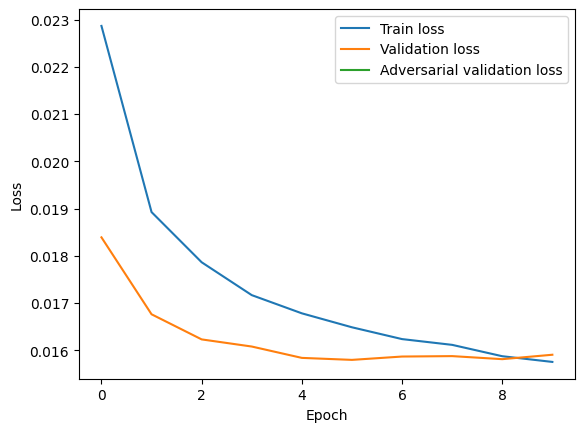

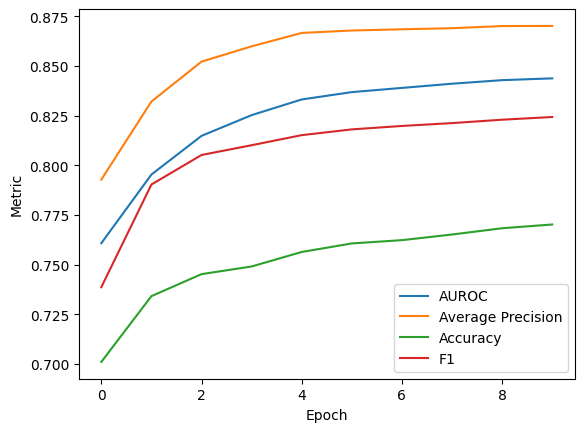

Max AP: 0.8702115009378065


In [10]:
aurocs = []

# Load the metrics for models/sex/ptb_20_apgd_1e-2_code15ft_lr1e-4_div1 div10 and div100
metrics = torch.load('../models/sex/ptb_20_apgd_1e-2_code15ft_lr1e-4_div1/metrics.pth')
# Get the final auroc
aurocs.append(metrics['auroc'][-1])
metrics = torch.load('../models/sex/ptb_20_apgd_1e-2_code15ft_lr1e-4_div10/metrics.pth')
aurocs.append(metrics['auroc'][-1])
metrics = torch.load('../models/sex/ptb_20_apgd_1e-2_code15ft_lr1e-4_div100/metrics.pth')
aurocs.append(metrics['auroc'][-1])

# Load the same metrics for base model models/sex/ptb_20_code15ft_lr1e-4_div1 div10 and div100
aurocs_base = []
metrics = torch.load("../models/sex/ptb_20_code15ft_lr1e-4_div1/metrics.pth")
aurocs_base.append(metrics['auroc'][-1])
metrics = torch.load("../models/sex/ptb_20_code15ft_lr1e-4_div10/metrics.pth")
aurocs_base.append(metrics['auroc'][-1])
metrics = torch.load("../models/sex/ptb_20_code15ft_lr1e-4_div100/metrics.pth")
aurocs_base.append(metrics['auroc'][-1])

print(aurocs)
print(aurocs_base)

# Plot aurocs and aurocs_base vs. div
div = ["10\%", "1\%", "0.1\%"]

# metrics = torch.load('../models/sex/ptb_20_apgd_1e-2_code15ft_lr1e-4_div1/metrics.pth')
# aurocs = metrics['auroc']
# metrics = torch.load("../models/sex/ptb_20_code15ft_lr1e-4_div1/metrics.pth")
# aurocs_base = metrics['auroc']


# Plot eps vs ap for each model
import matplotlib as mpl

plt.style.use(['../figures/style.mpl'])

labels = ["base fine-tuned", "adv. 1e-2"]
colors = ["blue", "green"]
linestyles = ['-', '-.']

plt.grid()
# change figure size
plt.plot(div, aurocs_base, marker='o', color='blue', linestyle='-')
plt.plot(div, aurocs, marker='o', color='green', linestyle='-.')



fig = plt.gcf()
fig.set_size_inches(6, 4)
# make it higher resolution
mpl.rcParams['figure.dpi'] = 300
# Set font size
plt.xticks(fontsize=12)
# make y ticks every 0.2
plt.yticks(np.arange(0.7, 0.95, 0.05), fontsize=12)

# set remaining fonts such as axis and legend
plt.legend(labels, fontsize=12)
plt.xlabel('Training size', fontsize=12)
plt.ylabel('AUROC', fontsize=12)

plt.savefig('../figures/frac_vs_perf_sex.pdf', bbox_inches='tight')
plt.show()




# # Plot the training and validation loss
# plt.figure()
# plt.plot(metrics['train_loss'], label='Train loss')
# plt.plot(metrics['valid_loss'], label='Validation loss')
# plt.plot(metrics['adv_valid_loss'], label='Adversarial validation loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot the AUROC, AP, accuracy and F1
# plt.figure()
# plt.plot(metrics['auroc'], label='AUROC')
# plt.plot(metrics['ap'], label='Average Precision')
# plt.plot(metrics['accuracy'], label='Accuracy')
# plt.plot(metrics['f1'], label='F1')
# plt.xlabel('Epoch')
# plt.ylabel('Metric')
# plt.legend()
# plt.show()

# # Print max AP 
# max_ap = max(metrics['ap'])
# print(f"Max AP: {max_ap}")

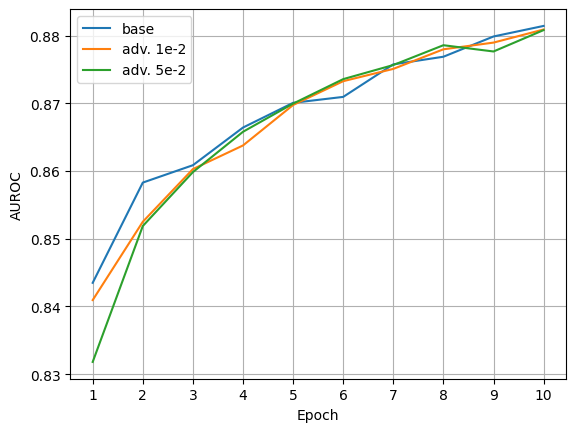

In [8]:
# Load the metrics for each model
models = ['../models/sex/ptb_20_code15ft_lr1e-4_div1', '../models/sex/ptb_20_apgd_1e-2_code15ft_lr1e-4_div1', '../models/sex/ptb_20_apgd_5e-2_code15ft_lr1e-4_div1']
epochs_range = range(1, num_epochs+1)

plt.figure()
for model in models:
    loaded_metrics = torch.load(model + '/metrics.pth')
    auroc = loaded_metrics['auroc']
    plt.plot(epochs_range, auroc)

plt.xticks(epochs_range)
#plt.yticks(np.arange(0.7, 0.9, 0.05))
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.grid()
plt.legend(["base", "adv. 1e-2", "adv. 5e-2"])
plt.show()

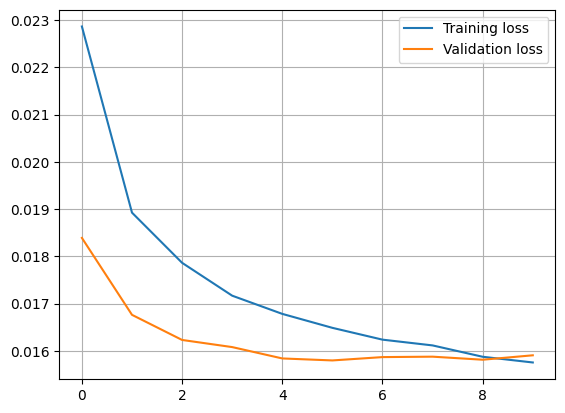

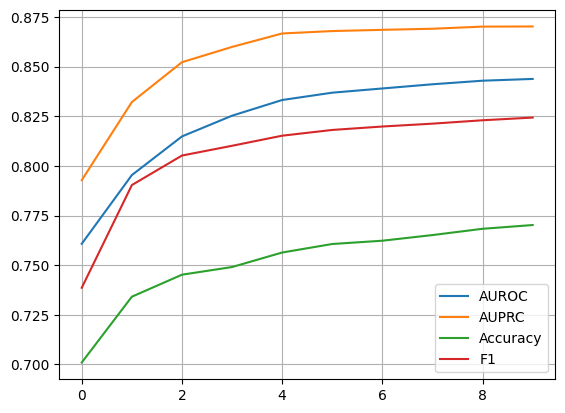

In [12]:
# plot training and validation loss
plt.figure()
plt.plot(train_loss_all, label='Training loss')
plt.plot(valid_loss_all, label='Validation loss')
plt.legend()
plt.grid()
plt.show()

# plot validation metrics
plt.figure()
plt.plot(auroc_all, label='AUROC')
plt.plot(ap_all, label='AUPRC')
plt.plot(accuracy_all, label='Accuracy')
plt.plot(f1_all, label='F1')
plt.legend()
plt.grid()
plt.show()